In [71]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [72]:
data = pd.read_csv('files/merged_movies.csv')

In [73]:
# drop duplicates
data = data.drop_duplicates(subset ='tconst')

### For now use the weighted rating as outcome

In [74]:
print(data.shape)
data.columns

(33295, 37)


Index(['tconst', 'primaryTitle', 'originalTitle', 'runtimeMinutes', 'genres_x',
       'averageRating', 'numVotes', 'has_well_known_director',
       'directors_name', 'has_well_known_actors', 'primary_actors', 'id_int',
       'keywords', 'belongs_to_collection', 'budget', 'genres_y', 'homepage',
       'original_language', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'tagline', 'vote_average', 'vote_count',
       'weighted_rating', 'adjusted_budget', 'adjusted_revenue',
       'original_english', 'has_production_companies',
       'is_top_production_company', 'release_month', 'has_tag_line'],
      dtype='object')

### Select cols for model

In [75]:
cols = ['tconst','runtimeMinutes', 'averageRating','numVotes','weighted_rating', 'runtime','vote_average','vote_count', # important features
        'genres_x', 'genres_y', 'adjusted_budget', 'adjusted_revenue', 'release_month', # possible predictive features
        'has_well_known_director','has_well_known_actors', 'is_top_production_company', # binary extracted features
        'production_countries','belongs_to_collection','has_tag_line','homepage','spoken_languages','original_english',
        'popularity','keywords','overview','directors_name','primary_actors' 
        ]
movie_models = data[cols]

In [76]:
# for now select those with at least 5k votes
movie_models = movie_models[movie_models['numVotes'] > 5000]

In [77]:
remove_for_now_cols = ['runtime','vote_average','vote_count','averageRating','numVotes','genres_y','adjusted_revenue','popularity']
model_cols = [col for col in movie_models.columns if col not in remove_for_now_cols]
movie_models = movie_models[model_cols]

In [79]:
movie_models.isnull().sum()

tconst                         0
runtimeMinutes                 0
weighted_rating                0
genres_x                       0
adjusted_budget                1
release_month                  1
has_well_known_director        0
has_well_known_actors          0
is_top_production_company      0
production_countries           0
belongs_to_collection          0
has_tag_line                   0
homepage                       0
spoken_languages               0
original_english               0
keywords                       0
overview                      23
directors_name                 1
primary_actors               271
dtype: int64

In [80]:
# same size as basic data
movie_models = movie_models[movie_models['adjusted_budget'].notnull()]

In [81]:
# binary weighted rating for now
movie_models['weighted_rating'] = (movie_models['weighted_rating'] > 7).astype(int)

### Preprocessing

#### Filter those with budget > 0

In [82]:
movie_models = movie_models[movie_models['adjusted_budget'] > 0]

In [83]:
movie_models.shape

(6189, 19)

#### Select text data

In [84]:
movie_models.columns

Index(['tconst', 'runtimeMinutes', 'weighted_rating', 'genres_x',
       'adjusted_budget', 'release_month', 'has_well_known_director',
       'has_well_known_actors', 'is_top_production_company',
       'production_countries', 'belongs_to_collection', 'has_tag_line',
       'homepage', 'spoken_languages', 'original_english', 'keywords',
       'overview', 'directors_name', 'primary_actors'],
      dtype='object')

In [85]:
movie_models = movie_models[['tconst','keywords','overview','directors_name','primary_actors','weighted_rating']]

In [86]:
import ast

In [87]:
def get_keywords(string):
    string_li = ast.literal_eval(string)
    return ','.join(string_li)

movie_models['keywords'] = movie_models['keywords'].apply(get_keywords)

In [88]:
movie_models = movie_models.fillna('')

In [89]:
print(movie_models['tconst'].is_unique)
movie_models.head()

True


,tconst,keywords,overview,directors_name,primary_actors,weighted_rating
21,tt0004972,,The Birth of A Nation is a silent film from 19...,D.W. Griffith,"Lillian Gish,Mae Marsh,Henry B. Walthall",0
33,tt0006864,,"The story of a poor young woman, separated by ...",D.W. Griffith,"Lillian Gish,Robert Harron,Mae Marsh",0
62,tt0010323,,The Cabinet of Dr. Caligari is eerie and expre...,Robert Wiene,"Werner Krauss,Conrad Veidt,Friedrich Feher",1
86,tt0012349,,Considered one of Charlie Chaplin's best films...,Charles Chaplin,"Charles Chaplin,Edna Purviance,Jackie Coogan",1
101,tt0013427,,This pioneering documentary film depicts the l...,Robert J. Flaherty,"Allakariallak,Alice Nevalinga,Cunayou",0


#### Try to get keywords from plot

In [90]:
# from keybert import KeyBERT
# kw_model = KeyBERT(model='all-mpnet-base-v2')

In [91]:
# def get_keyword(text):
#     keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 2), stop_words='english', highlight=False, top_n=3)

#     keywords_list = list(dict(keywords).keys())
#     return keywords_list

# from tqdm import tqdm

# all_keywords = []

# for keyword in tqdm(movie_models['overview']):
#     all_keywords.append(get_keyword(keyword))

In [92]:
# movie_models['keywords_extract'] = all_keywords
# movie_models.to_csv('movie_models_with_keywords.csv')movie_models.to_csv('movie_models_with_keywords.csv')

#### Combine features into text

In [93]:
# use this data with keywords
movie_keywords= pd.read_csv('files/movie_models_with_keywords.csv')

In [129]:
# function to check keyword from plot
def random_overview():
    sample = movie_keywords.sample(1)
    print(sample['overview'].values[0])
    print('*' * 100)
    print('Keywords:',sample['keywords_extract'].values[0])

random_overview()

God contacts Congressman Evan Baxter and tells him to build an ark in preparation for a great flood.
****************************************************************************************************
Keywords: ['build ark', 'great flood', 'ark']


In [95]:
# get keywords
movie_models = movie_models.merge(movie_keywords[['tconst','keywords_extract']], how = 'inner', on ='tconst')

In [96]:
movie_models = movie_models[['keywords','directors_name','primary_actors','keywords_extract','weighted_rating']]
movie_models.head()

,keywords,directors_name,primary_actors,keywords_extract,weighted_rating
0,,D.W. Griffith,"Lillian Gish,Mae Marsh,Henry B. Walthall","['history film', 'film 1915', 'birth nation']",0
1,,D.W. Griffith,"Lillian Gish,Robert Harron,Mae Marsh","['tales intolerance', 'intolerance history', '...",0
2,,Robert Wiene,"Werner Krauss,Conrad Veidt,Friedrich Feher","['dr caligari', 'caligari eerie', 'caligari']",1
3,,Charles Chaplin,"Charles Chaplin,Edna Purviance,Jackie Coogan","['jackie coogan', 'charlie chaplin', 'little j...",1
4,,Robert J. Flaherty,"Allakariallak,Alice Nevalinga,Cunayou","['indigenous inuit', 'inuit people', 'inuit']",0


#### Clean features and combine

In [97]:
def separate_keywords(keywords_list):
    keywords = ast.literal_eval(keywords_list)
    return ' '.join(keywords)

In [98]:
movie_models['keywords_extract'] = movie_models['keywords_extract'].apply(separate_keywords)

In [99]:
movie_models[['directors_name','primary_actors']] = movie_models[['directors_name','primary_actors']].applymap(lambda x: x.replace(',', ' '))

In [100]:
movie_models['text_feature'] =  movie_models[['keywords','directors_name','primary_actors','keywords_extract']].apply(lambda row: ' '.join(row.values.astype(str)), axis = 1)

In [101]:
# save copy
movie_models_original = movie_models.copy()

In [102]:
movie_models = movie_models[['text_feature','weighted_rating']]

In [103]:
movie_models.head()

,text_feature,weighted_rating
0,D.W. Griffith Lillian Gish Mae Marsh Henry B....,0
1,D.W. Griffith Lillian Gish Robert Harron Mae ...,0
2,Robert Wiene Werner Krauss Conrad Veidt Fried...,1
3,Charles Chaplin Charles Chaplin Edna Purvianc...,1
4,Robert J. Flaherty Allakariallak Alice Nevali...,0


#### Split train and test set

In [104]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(movie_models['text_feature'], movie_models['weighted_rating'], 
                                        stratify= movie_models['weighted_rating'], test_size=.25, random_state=42)

In [105]:
print(X_train.shape)
print(X_test.shape)
print(y_train.mean())
print(y_test.mean())

(4641,)
(1548,)
0.23249299719887956
0.23255813953488372


### Modeling

Fit several models.

#### Naive Bayes

In [106]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from time import time

nb_pipeline = Pipeline([('tfidf', TfidfVectorizer(analyzer= 'word', stop_words='english')),
                        ('nb_clf', MultinomialNB())])

nb_params = {
    'tfidf__strip_accents': ['ascii','unicode',None],
    'tfidf__ngram_range' : [(1,2), (1,3)],
    'tfidf__max_df': (0.5, .75 , 1.0),
    'nb_clf__alpha':  np.arange(0.01, 1.01, .01)

}

nb_grid = RandomizedSearchCV(nb_pipeline, param_distributions= nb_params, scoring='f1',  n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
start = time()
nb_grid.fit(X_train, y_train)
end = time()
print('Model fitting_time: ', end - start)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Model fitting_time:  42.87541699409485


In [107]:
# best estimator
best_nb = nb_grid.best_estimator_
print('Best F1 Score', nb_grid.best_score_)
print('Vocabulary size: ', best_nb['tfidf'].transform(X_train).shape[1])
best_nb

Best F1 Score 0.3282407407407407
Vocabulary size:  122451


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.75, ngram_range=(1, 3),
                                 stop_words='english')),
                ('nb_clf', MultinomialNB(alpha=0.02))])

              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1188
           1       0.47      0.32      0.38       360

    accuracy                           0.76      1548
   macro avg       0.64      0.60      0.61      1548
weighted avg       0.73      0.76      0.74      1548

AUC train:1.0
AUC test :0.703

Logloss 8.344705891581176
****************************************************************************************************
Confusion matrix


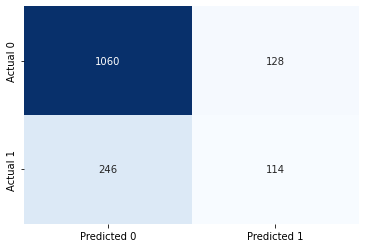

In [108]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, log_loss, f1_score
import seaborn as sns 

def measure_metrics(model, y_pred, y_true, X_train = X_train, X_test = X_test):
     print(classification_report(y_pred= y_pred, y_true= y_test))
     proba_train = model.predict_proba(X_train)[:,1]
     proba_test = model.predict_proba(X_test)[:,1]
     
     print(f"AUC train:{round(roc_auc_score(y_train, proba_train),4)}")
     print(f"AUC test :{round(roc_auc_score(y_test, proba_test),4)}\n")
     print('Logloss', log_loss(y_pred= y_pred, y_true= y_test))

     print('*' * 100)
     print('Confusion matrix')     
     cm = confusion_matrix(y_pred= y_pred, y_true= y_test)
     g = sns.heatmap(cm, annot=True, cbar = False, fmt = 'g', cmap ='Blues')
     g.set_yticklabels(['Actual 0', 'Actual 1'])
     g.set_xticklabels(['Predicted 0', 'Predicted 1'])


y_pred = best_nb.predict(X_test)
measure_metrics(best_nb, y_pred, y_test)

#### Try linear regression

In [109]:
from sklearn.linear_model import LogisticRegression

lr_pipeline = Pipeline([('tfidf', TfidfVectorizer(analyzer= 'word', stop_words='english')),
                        ('lr_clf', LogisticRegression())])

lr_params = {
    'tfidf__strip_accents': ['ascii','unicode',None],
    'tfidf__ngram_range' : [(1,2), (1,3)],
    'tfidf__max_df': (0.5, .75 , 1.0),
    'lr_clf__penalty':  ('l1','l2','elasticnet'),
    'lr_clf__C': np.arange(0.1, 100.1, .1),
    'lr_clf__class_weight': ['balanced', {0:1,1:2}, {0:1, 1:3}]
}


lr_grid = RandomizedSearchCV(lr_pipeline, param_distributions= lr_params, scoring='f1',  n_iter = 100, cv = 3, verbose=0, random_state=42, n_jobs = -1)
start = time()
lr_grid.fit(X_train, y_train)
end = time()
print('Model fitting_time: ', end - start)


C:\Users\ROG\anaconda3\envs\ML_envi\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.34140577        nan        nan        nan        nan        nan
 0.32590624        nan 0.35198366 0.32527657 0.34125336        nan
        nan        nan 0.35308498        nan        nan        nan
 0.34765256        nan        nan 0.33230403        nan 0.29835794
 0.29443236        nan 0.34106898        nan        nan 0.29786639
        nan        nan        nan        nan        nan 0.35306399
        nan        nan        nan        nan 0.31305247        nan
 0.34362705        nan        nan        nan        nan        nan
        nan 0.34201365        nan        nan        nan        nan
 0.35244612        nan        nan        nan        nan        nan
 0.33832992 0.3433869  0.32775773        nan 0.3515861         nan
 0.35128677        nan 0.35194656 0.28605456        nan        nan
 0.34578427 0.3250297  0.34449217        n

Model fitting_time:  75.52191948890686


In [110]:
# best estimator
best_lr = lr_grid.best_estimator_
print('Best F1 Score', lr_grid.best_score_)
print('Vocabulary size: ', best_lr['tfidf'].transform(X_train).shape[1])
best_lr

Best F1 Score 0.353084978547853
Vocabulary size:  65570


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.5, ngram_range=(1, 2),
                                 stop_words='english')),
                ('lr_clf',
                 LogisticRegression(C=40.1, class_weight='balanced'))])

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1188
           1       0.45      0.34      0.38       360

    accuracy                           0.75      1548
   macro avg       0.63      0.61      0.61      1548
weighted avg       0.73      0.75      0.74      1548

AUC train:1.0
AUC test :0.7025

Logloss 8.70170822533886
****************************************************************************************************
Confusion matrix


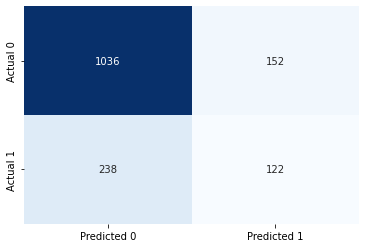

In [111]:
y_pred = best_lr.predict(X_test)
measure_metrics(best_lr, y_pred, y_test)

#### Manual fitting of LR

In [112]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), stop_words='english')
tfidf_vectorizer = tfidf_vectorizer.fit(X_train)
X_train_trans = tfidf_vectorizer.transform(X_train)
X_test_trans = tfidf_vectorizer.transform(X_test)

# Fit several KNN model by varying k
Cs = []
scores = []


start = time()
# use low C to for plotting
for C in np.arange(0.1, 100.1, .1):
    lr_clf = LogisticRegression(C = C, solver='liblinear', multi_class="auto")
    lr_clf = lr_clf.fit(X_train_trans, y_train)

    # predictions
    y_pred = lr_clf.predict(X_test_trans)
    score = f1_score(y_true= y_test, y_pred= y_pred, average= 'weighted') 
    Cs.append(C)
    scores.append(score)
print('Model fitting time:', end - start)

# create dataframe from results
LR_df = pd.DataFrame({
    'Score':scores,
    'C':Cs,
})

print('Top 3 inverse of regularization (C) with the highest F1 Scores')
LR_df.sort_values(by = 'Score', ascending = False).head(3)

Model fitting time: -1.7314369678497314
Top 3 inverse of regularization (C) with the highest F1 Scores


,Score,C
500,0.73833,50.1
518,0.73833,51.9
516,0.73833,51.7


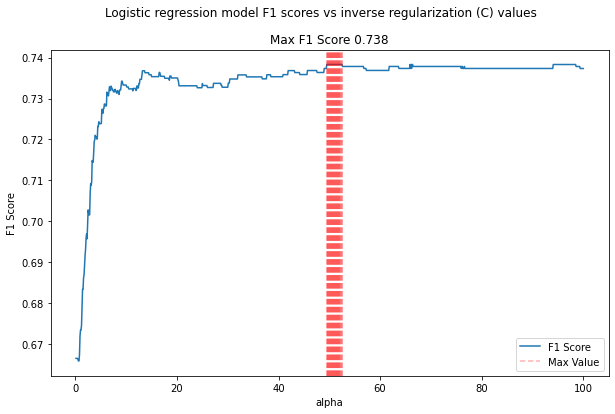

In [113]:
plt.figure(figsize = (10,6))
plt.plot(LR_df['C'], LR_df['Score'])
plt.suptitle('Logistic regression model F1 scores vs inverse regularization (C) values')
plt.title(f'Max F1 Score {np.round(LR_df["Score"].max(), 3)}')
plt.ylabel('F1 Score')
plt.xlabel('alpha')
for highest_index in np.where(LR_df['Score'] == LR_df['Score'].max())[0]:
    plt.axvline(LR_df.loc[highest_index, 'C'], color = 'red', alpha = .3, linestyle = '--')

plt.legend(('F1 Score','Max Value'))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86      1188
           1       0.51      0.25      0.34       360

    accuracy                           0.77      1548
   macro avg       0.66      0.59      0.60      1548
weighted avg       0.73      0.77      0.74      1548

AUC train:1.0
AUC test :0.7025

Logloss 7.965382905658618
****************************************************************************************************
Confusion matrix


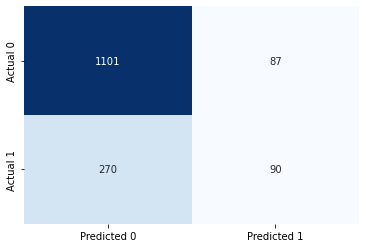

In [114]:
## best LR model
best_manual_LR_clf = LogisticRegression(C = 50.1, solver='liblinear', multi_class="auto")
best_manual_LR_clf.fit(X_train_trans, y_train)
y_pred = best_manual_LR_clf.predict(X_test_trans)

measure_metrics(best_manual_LR_clf, y_pred, y_test, X_train= X_train_trans, X_test= X_test_trans)

LR from random search has better f1 score, whereas manual LR has better precision but very low recall.

#### Plot top features

In [115]:
coefficients_manual = pd.DataFrame({"keywords":tfidf_vectorizer.get_feature_names(),
                             "coef":best_manual_LR_clf.coef_[0]})
coefficients_random_cv = pd.DataFrame({"keywords":best_lr['tfidf'].get_feature_names(),
                             "coef": best_lr['lr_clf'].coef_[0]})

In [116]:
def plot_lr_coef(df, title = 'Top weighted_keywords', pos_adjust = .3, neg_adjust = 1.5, xlim = (-10,10)):
    worse_coef = df.sort_values(by = 'coef', ascending = False).head(20)
    best_coef = df.sort_values(by = 'coef',  ascending = False).tail(20)
    for_plotting =  pd.concat([worse_coef, best_coef]).drop_duplicates(subset = 'coef')

    def plot(temp_table):
        if temp_table['coef'].values < 0:
            plt.text( temp_table['coef'].values - neg_adjust ,i , temp_table['keywords'].values[0])
        else:
            plt.text(temp_table['coef'].values + pos_adjust ,i , temp_table['keywords'].values[0])

    with sns.axes_style({
    'xtick.bottom': False,
    'xtick.top': False,
    'ytick.left': False,
    'ytick.right': False,
    'axes.spines.left': False,
    'axes.spines.bottom': False,
    'axes.spines.right': False,
    'axes.spines.top': False
    }):
        plt.figure(figsize = (12,12))
        plt.title(title, fontsize = 20)
        ax = sns.barplot(x='coef', y='keywords', data=for_plotting, palette='RdYlBu_r', edgecolor='black')
        ax.set_xlabel('Coefficients')
        ax.set_ylabel('')
        ax.set_xlim(xlim)
        ax.set_yticks([])
        for i, name in enumerate(for_plotting.keywords): 
            temp_table = for_plotting[for_plotting['keywords'] == name]
            plot(temp_table)


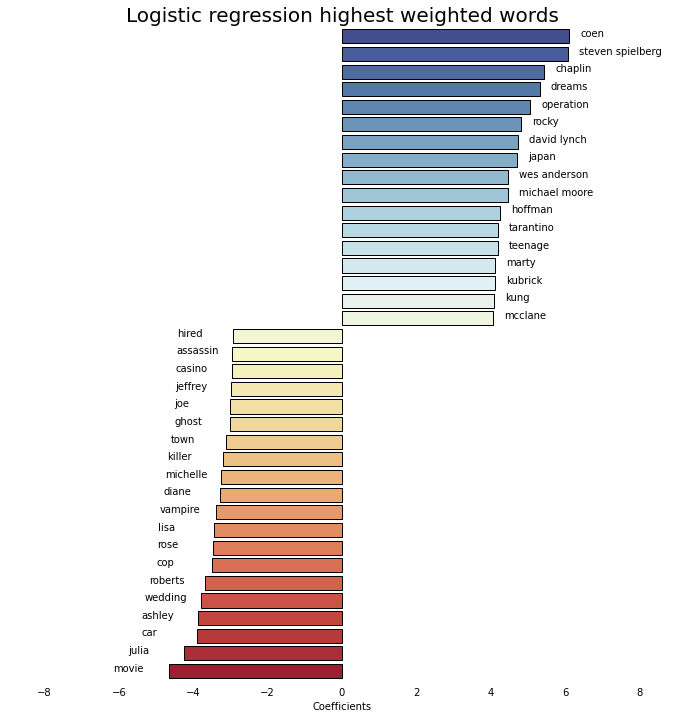

In [117]:
plot_lr_coef(coefficients_random_cv, title = 'Logistic regression highest weighted words', xlim = (-9, 9))

#### SGD Classifier

In [118]:
from sklearn.linear_model import SGDClassifier

sgd_pipeline = Pipeline([('tfidf', TfidfVectorizer(analyzer= 'word', stop_words='english')),
                        ('sgd_clf', SGDClassifier(loss = 'hinge', random_state= 1234))])

sgd_params = {
    'tfidf__strip_accents': ['ascii','unicode',None],
    'tfidf__ngram_range' : [(1,2), (1,3)],
    'tfidf__max_df': (0.5, .75 , 1.0),
    'sgd_clf__alpha': (1.0000000000000001e-05, 9.9999999999999995e-07),
    'sgd_clf__max_iter': (10, 50, 80),
    'sgd_clf__penalty': ('l2', 'elasticnet'),
}


sgd_grid = RandomizedSearchCV(sgd_pipeline, param_distributions= sgd_params, scoring='f1',  n_iter = 100, cv = 3, verbose=0, random_state=42, n_jobs = -1)
start = time()
sgd_grid.fit(X_train, y_train)
end = time()
print('Model fitting_time: ', end - start)


Model fitting_time:  43.42847418785095


C:\Users\ROG\anaconda3\envs\ML_envi\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


In [119]:
# best estimator
best_sgd = sgd_grid.best_estimator_
print('Best F1 Score', sgd_grid.best_score_)
print('Vocabulary size: ', best_sgd['tfidf'].transform(X_train).shape[1])
best_sgd

Best F1 Score 0.3401543795061825
Vocabulary size:  65479


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(ngram_range=(1, 2), stop_words='english',
                                 strip_accents='unicode')),
                ('sgd_clf',
                 SGDClassifier(alpha=1e-06, max_iter=10, penalty='elasticnet',
                               random_state=1234))])

In [120]:
from sklearn.metrics import roc_auc_score
# not sure if comparable with other AUC
best_sgd.decision_function(X_train)

array([-4.50465001, -6.13478333,  6.89489225, ..., -5.86349991,
        6.96950047, -6.41379335])

              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1188
           1       0.45      0.30      0.36       360

    accuracy                           0.75      1548
   macro avg       0.63      0.59      0.60      1548
weighted avg       0.72      0.75      0.73      1548

Logloss 8.545514280693892
****************************************************************************************************
Confusion matrix


[Text(0.5, 0, 'Predicted 0'), Text(1.5, 0, 'Predicted 1')]

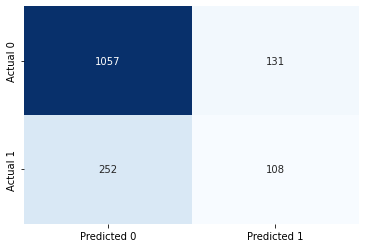

In [121]:
# predict
# manual since it does not predict probability
y_pred = best_sgd.predict(X_test)
print(classification_report(y_pred= y_pred, y_true= y_test))
print('Logloss', log_loss(y_pred= y_pred, y_true= y_test))
print('*' * 100)
print('Confusion matrix')     
cm = confusion_matrix(y_pred= y_pred, y_true= y_test)
g = sns.heatmap(cm, annot=True, cbar = False, fmt = 'g', cmap ='Blues')
g.set_yticklabels(['Actual 0', 'Actual 1'])
g.set_xticklabels(['Predicted 0', 'Predicted 1'])

Similar performance with LR

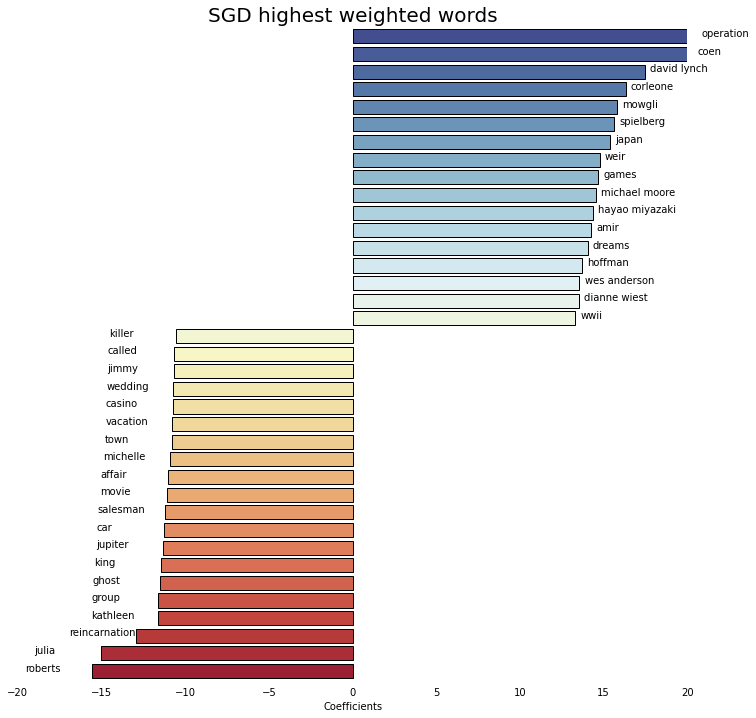

In [122]:
coefficients_sgd = pd.DataFrame({"keywords":best_sgd['tfidf'].get_feature_names(),
                             "coef": best_sgd['sgd_clf'].coef_[0]})

plot_lr_coef(coefficients_sgd, title='SGD highest weighted words', xlim=(-20, 20), neg_adjust= 4)

#### manually search plot for keywords

In [136]:
def find_movie(word, col = 'overview', sample = 1):

    with_word = movie_models[movie_models['text_feature'].str.contains(word)]
    num_movies = len(with_word)
    with_word = with_word.sample(sample)
    
    print(f'Movie keyword with word {num_movies}')
    print(f'Percent high rated movies: ', with_word['weighted_rating'].mean())
    print('\n')

    for search in movie_keywords[movie_keywords.index.isin(with_word.index)][col]:
        print('*'* 100)
        print(search)


find_movie('chinese')

Movie keyword with word 18
Percent high rated movies:  0.0


****************************************************************************************************
A detective from Hong Kong teams up with an American gambler to battle against a notorious Chinese criminal.


In [143]:
def find_feature(keyword):
    with_word = movie_models[movie_models['text_feature'].str.contains(keyword)]
    print('Number of movies: ', len(with_word))
    print(f'Percent high rated movies: ', with_word['weighted_rating'].mean())
    display(with_word)

find_feature('Hayao')

Number of movies:  7
Percent high rated movies:  1.0


,text_feature,weighted_rating
844,Hayao Miyazaki Sumi Shimamoto Mahito Tsujimur...,1
1188,Hayao Miyazaki Kirsten Dunst Minami Takayama ...,1
1957,Hayao Miyazaki Yôji Matsuda Yuriko Ishida Yûk...,1
2575,Hayao Miyazaki Daveigh Chase Suzanne Pleshett...,1
3053,Hayao Miyazaki Chieko Baishô Takuya Kimura Ta...,1
4065,Hayao Miyazaki Cate Blanchett Matt Damon Liam...,1
5416,Hayao Miyazaki Hideaki Anno Hidetoshi Nishiji...,1


## Plots

In [124]:
def subplot_lr_coef(df, title = 'Top weighted_keywords', pos_adjust = .3, neg_adjust = 1.5, xlim = (-10,10)):
    worse_coef = df.sort_values(by = 'coef', ascending = False).head(20)
    best_coef = df.sort_values(by = 'coef',  ascending = False).tail(20)
    for_plotting =  pd.concat([worse_coef, best_coef]).drop_duplicates(subset = 'coef')

    def plot(temp_table):
        if temp_table['coef'].values < 0:
            plt.text( temp_table['coef'].values - neg_adjust ,i , temp_table['keywords'].values[0])
        else:
            plt.text(temp_table['coef'].values + pos_adjust ,i , temp_table['keywords'].values[0])

    with sns.axes_style({
    'xtick.bottom': False,
    'xtick.top': False,
    'ytick.left': False,
    'ytick.right': False,
    'axes.spines.left': False,
    'axes.spines.bottom': False,
    'axes.spines.right': False,
    'axes.spines.top': False
    }):
        plt.title(title, fontsize = 20)
        ax = sns.barplot(x='coef', y='keywords', data=for_plotting, palette='RdYlBu_r', edgecolor='black')
        ax.set_xlabel('Coefficients')
        ax.set_ylabel('')
        ax.set_xlim(xlim)
        ax.set_yticks([])
        for i, name in enumerate(for_plotting.keywords): 
            temp_table = for_plotting[for_plotting['keywords'] == name]
            plot(temp_table)


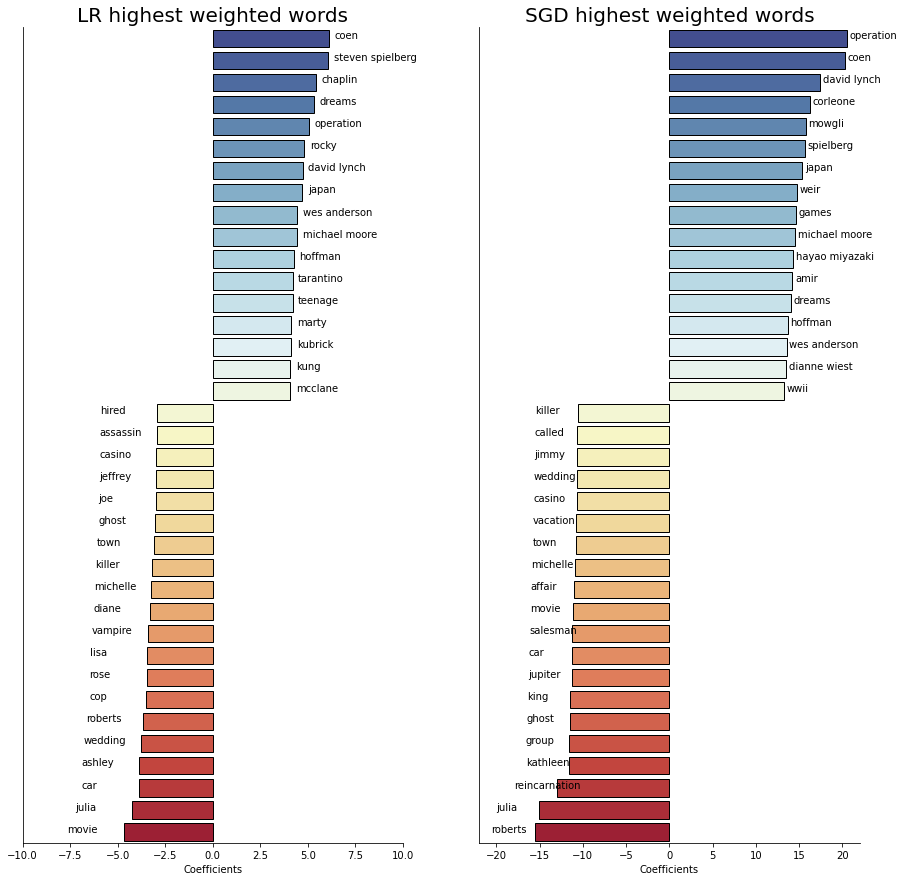

In [125]:
with sns.axes_style({
'xtick.bottom': True,
 'xtick.top': False,
 'ytick.left': True,
 'ytick.right': False,
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': False,
 'axes.spines.top': False
}):
        
    plt.figure(figsize = (15,15))
    plt.subplot(1,2,1)
    subplot_lr_coef(coefficients_random_cv, title = 'LR highest weighted words', xlim = (-10, 10), neg_adjust= 3)

    plt.subplot(1,2,2)
    subplot_lr_coef(coefficients_sgd, title='SGD highest weighted words', xlim=(-22, 22), neg_adjust= 5)